С одной эпохой результат не очень хороший. Но обучается долго, а надо двигаться дальше. Как посчитается 12 эпох, заменю ноутбук. 

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import skimage.io as io
import numpy as np
import tensorflow as tf
import random
# import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Загрузка датасета COCO и COCO API

In [0]:
if 0:
    # !mkdir -p data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    # !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    # !cd data && unzip -q train2017.zip
    # !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    # !cd data && git clone https://github.com/cocodataset/cocoapi
    # !cd data/cocoapi/PythonAPI && make

## Подготовка COCO API

In [0]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [0]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [0]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [0]:
class ASPPBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=6, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=12, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(256, (3, 3), dilation_rate=18, padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (1, 1), padding='same', activation='relu')

    def call(self, inp, is_training=False):
        out1 = self.conv1(inp)
        out2 = self.conv2(inp)
        out3 = self.conv3(inp)
        out4 = self.conv4(inp)
        out = tf.concat([out1, out2, out3, out4], axis=3)
        out = self.conv5(out)
        return out
    
class ASPPNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')

        self.conv11 = tf.keras.layers.Conv2D(48, (1, 1), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation=None)

        self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPPBlock()

    def call(self, x):

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.maxpool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.maxpool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.maxpool(out)
        out = self.conv9(out)
        out = self.conv10(out)

        out = self.aspp(out)

        out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)

        out_enc_mid = self.conv11(out_enc_mid)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv12(out)
        out = self.conv13(out)
        out = self.conv14(out)

        out = tf.image.resize(out, tf.shape(x)[1:3], tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

## Работа с датасетом

In [28]:
dataDir='./data'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=2.09s)
creating index...
index created!
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'n

In [30]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(1, cats))

The class name is person


Number of images containing all the classes: 2693


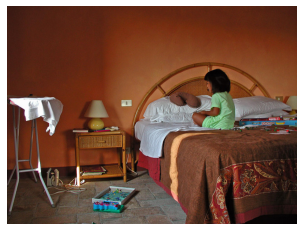

In [32]:
# Define the classes (out of the 81) which we want to see. Others classes will not be shown.
# filterClasses = ['laptop', 'tv', 'cell phone']
filterClasses = ['person']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the classes:", len(imgIds))

# Load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/{}/{}'.format(dataDir,dataType,img['file_name']))/255.

plt.axis('off')
plt.imshow(I)
plt.show()

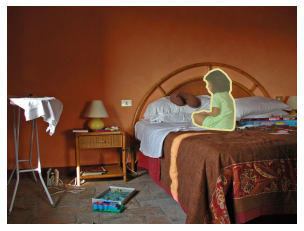

In [33]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [35]:
########## ALL POSSIBLE COMBINATIONS ########
classes = ['person']

images = []
if classes!=None:
    # Iterate for each individual class in the list
    for className in classes:
        # Get all images containing given class
        catIds = coco.getCatIds(catNms=className)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
else:
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    
# Filter out the repeated images    
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 2693


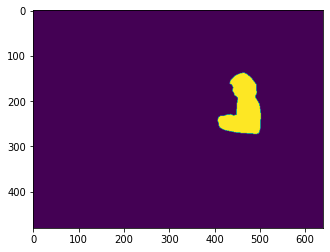

In [36]:
#### GENERATE A SEGMENTATION MASK ####
filterClasses = classes
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

In [0]:
# #### GENERATE A BINARY MASK ####
# mask = np.zeros((img['height'],img['width']))
# for i in range(len(anns)):
#     mask = np.maximum(coco.annToMask(anns[i]), mask)
# plt.imshow(mask)

In [0]:
def filterDataset(folder, classes=None, mode='train'):    
    # Initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # Iterate for each individual class in the list
        for className in classes:
            # Get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [41]:
folder = './data'
classes = ['person']
mode = 'val2017'

images, dataset_size, coco = filterDataset(folder, classes, mode)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [0]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None


def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    

def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    

def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        # Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): # Initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            # Retrieve Image
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            # Create Mask
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [0]:
batch_size = 4
input_image_size = (224,224)
mask_type = 'normal'

val_gen = dataGeneratorCoco(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

In [0]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

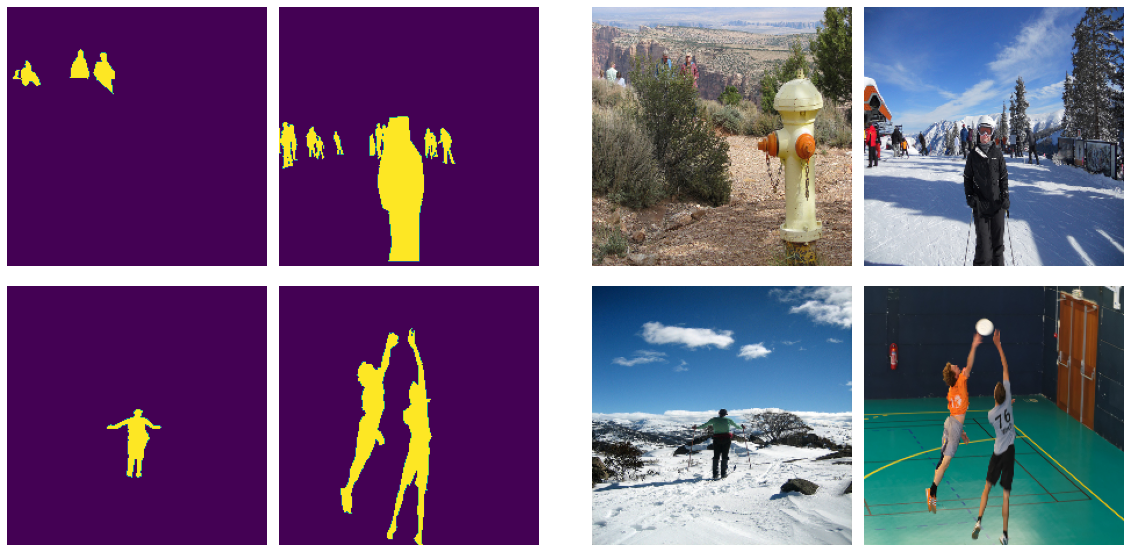

In [49]:
visualizeGenerator(val_gen)

In [0]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.
        
        mask_aug = next(g_y)

        yield img_aug, mask_aug

In [0]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

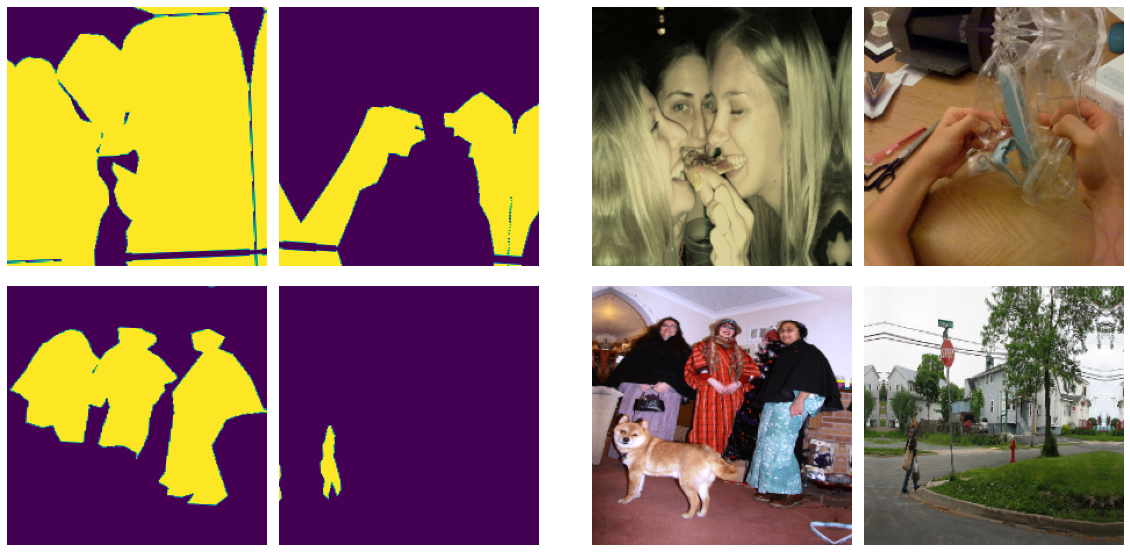

In [52]:
visualizeGenerator(aug_gen)

In [55]:
# Create filtered train dataset
mode_train = 'train2017'

images_train, dataset_train_size, coco_train = filterDataset(folder, classes, mode_train)

loading annotations into memory...
Done (t=13.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [0]:
# Create filtered test dataset
mode_test = 'val2017'

images_test, dataset_test_size, coco_test = filterDataset(folder, classes, mode_test)

In [0]:
# Create train generator (using dataGeneratorCoco()) 
batch_size = 32
input_image_size = (224,224)
mask_type = 'normal'

train_gen = dataGeneratorCoco(images_train, classes, coco_train, folder,
                              input_image_size, batch_size, mode_train, mask_type)

# Create test generator (using dataGeneratorCoco()) 
test_gen = dataGeneratorCoco(images_test, classes, coco_test, folder,
                              input_image_size, batch_size, mode_test, mask_type)

## Создание и тренировка модели

In [0]:
# Set parameters
n_epochs = 1

steps_per_epoch = dataset_train_size // batch_size
validation_steps = dataset_test_size // batch_size

model = ASPPNet()
optimizer = 'adam'
loss = tf.keras.losses.BinaryCrossentropy()

In [0]:
# Compile model
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [63]:
# Start the training process
history = model.fit(x = train_gen,
                    validation_data = test_gen,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    epochs = n_epochs,
                    verbose = True)

2003/2003 [==============================] - 1574s 786ms/step - loss: 0.3070 - accuracy: 0.8723 - val_loss: 0.2377 - val_accuracy: 0.8970


In [0]:
# plt.plot(history.history['loss'])

## Пример результата сегментации

In [72]:
if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png

--2020-06-02 22:20:12--  https://raw.githubusercontent.com/dkorobchenko-nv/person-segmentation/master/img/me_256.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118993 (116K) [image/png]
Saving to: ‘me_256.png’

me_256.png          100%[===================>] 116.20K  --.-KB/s    in 0.01s   

2020-06-02 22:20:12 (9.77 MB/s) - ‘me_256.png’ saved [118993/118993]



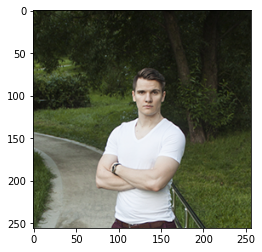

In [74]:
import imageio
img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255.
_=plt.imshow(img)

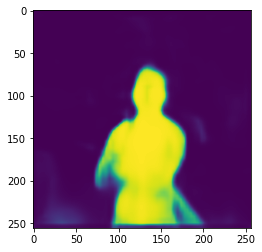

In [75]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[...,0])

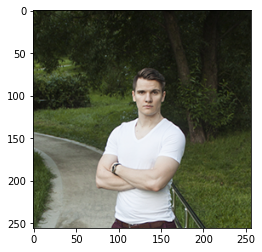

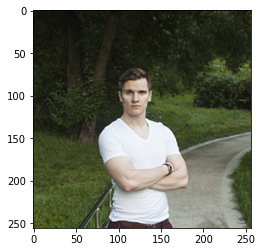

(<matplotlib.image.AxesImage at 0x7f8ca15594a8>, None)

In [78]:
train_y = np.stack((img, img[:,::-1,:]))

plt.imshow(train_y[0]), plt.show()
plt.imshow(train_y[1]), plt.show()

## Наложение карты сегментации на изображение

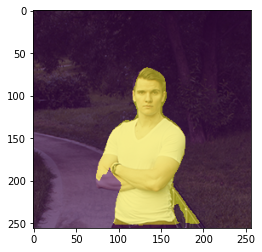

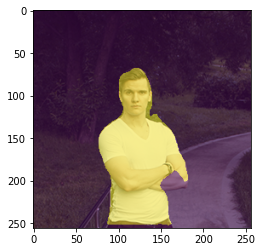

In [79]:
for sample in train_y:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()